In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random

from IPython.display import display, clear_output
from stable_fluid.fluid import Fluid
from matplotlib.collections import LineCollection
from noise import pnoise3  # pip install noise
import tqdm
#z, y, x순서임.

#근데 speed[0]은 x벡터의 크기, speed[1]은 y벡터의 크기, speed[2]는 z벡터의 크기 됨 주의.
RESOLUTION = 297, 210, 210
DT = 0.3 #simulation sparsity.
DURATION = 450 #total time. 

INFLOW_DURATION = 3000
INFLOW_TEMPERTURE = 1

num_polyline = 100
num_points = 1000

buoyancy_a = 0.05

z_start = 0

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device: ", device)

fluid = Fluid(RESOLUTION, 'dye', 'heat', device = device)

middle =int(RESOLUTION[1] / 2)
offset = 10

inflow_heat = torch.zeros(fluid.shape, device=device)
inflow_heat[z_start, middle-offset:middle+offset, middle-offset:middle+offset] += INFLOW_TEMPERTURE

inflow_dye = torch.zeros(fluid.shape, device=device)
inflow_dye[z_start, middle-offset:middle+offset, middle-offset:middle+offset] = 1


device:  cuda


In [3]:
def advect_polylines(vector_field: torch.Tensor, polylines: torch.Tensor, dt: float) -> torch.Tensor:
    """
    vector_field: (3, nz, ny, nx), vector_field[0] = u, vector_field[1] = v, vector_field[2] = w
    polylines: (num_polylines, num_points, 3)
    dt: float
    return: (num_polylines, num_points, 3), 좌표는 제한 없이 계속 확장됨
    """
    if polylines.numel() == 0:
        return polylines

    nz, ny, nx = vector_field.shape[1], vector_field.shape[2], vector_field.shape[3]

    # 좌표 분리
    x = polylines[..., 0]  # (N, P)
    y = polylines[..., 1]
    z = polylines[..., 2]

    # 속도 구할 때만 periodic index 적용
    x0 = torch.floor(x).long() % nx
    y0 = torch.floor(y).long() % ny
    z0 = torch.floor(z).long() % nz
    x1 = (x0 + 1) % nx
    y1 = (y0 + 1) % ny
    z1 = (z0 + 1) % nz

    sx = x - torch.floor(x)
    sy = y - torch.floor(y)
    sz = z - torch.floor(z)

    # ===== trilinear interpolation =====
    def trilerp(field):
        c000 = field[z0, y0, x0]
        c100 = field[z0, y0, x1]
        c010 = field[z0, y1, x0]
        c110 = field[z0, y1, x1]
        c001 = field[z1, y0, x0]
        c101 = field[z1, y0, x1]
        c011 = field[z1, y1, x0]
        c111 = field[z1, y1, x1]

        c00 = c000 * (1 - sx) + c100 * sx
        c01 = c001 * (1 - sx) + c101 * sx
        c10 = c010 * (1 - sx) + c110 * sx
        c11 = c011 * (1 - sx) + c111 * sx

        c0 = c00 * (1 - sy) + c10 * sy
        c1 = c01 * (1 - sy) + c11 * sy

        return c0 * (1 - sz) + c1 * sz

    u = trilerp(vector_field[0])
    v = trilerp(vector_field[1])
    w = trilerp(vector_field[2])

    # 좌표는 제한하지 않고 이동
    new_x = x + u * dt
    new_y = y + v * dt
    new_z = z + w * dt

    return torch.stack([new_x, new_y, new_z], dim=-1)


In [4]:
def redistribute_polyline_points(polylines: torch.Tensor) -> torch.Tensor:
    """
    polylines: (num_polylines, num_points, 3)
    return: (num_polylines, num_points, 3)

    각 polyline의 점 수를 유지하면서 점들의 위치를 일정 간격으로 재조정.
    """
    num_polylines, num_points, _ = polylines.shape
    device = polylines.device

    # segment 벡터 (B, N-1, 3)
    diffs = polylines[:, 1:, :] - polylines[:, :-1, :]

    # segment 길이 (B, N-1)
    dists = torch.linalg.norm(diffs, dim=2)

    # 누적 아크 길이 (B, N)
    cumdist = torch.cat(
        [torch.zeros((num_polylines, 1), device=device), torch.cumsum(dists, dim=1)],
        dim=1
    )

    total_len = cumdist[:, -1:]  # (B, 1)

    # 새로운 점들의 위치 (등간격) (B, N)
    new_pos = torch.linspace(0, 1, num_points, device=device).unsqueeze(0) * total_len

    # 각 new_pos가 속한 segment 찾기 (B, N)
    idx = torch.searchsorted(cumdist, new_pos, right=True) - 1
    idx = torch.clamp(idx, 0, num_points - 2)

    # seg 시작점 (B, N, 3)
    seg_start = torch.gather(polylines, 1, idx.unsqueeze(-1).expand(-1, -1, 3))

    # seg 벡터 (B, N, 3)
    seg_vec = torch.gather(diffs, 1, idx.unsqueeze(-1).expand(-1, -1, 3))

    # seg 길이 (B, N)
    seg_len = torch.gather(dists, 1, idx)

    seg_offset = new_pos - torch.gather(cumdist, 1, idx)  # (B, N)
    ratio = (seg_offset / (seg_len + 1e-8)).unsqueeze(-1)  # (B, N, 1)

    # 보간 결과 (B, N, 3)
    resampled = seg_start + seg_vec * ratio
    return resampled


In [5]:
def get_drawing_polylines(polylines):
    
    drawing_polylines = []
    res_tensor = torch.tensor((RESOLUTION[2], RESOLUTION[0]))  # (W,H) → 텐서로 변환
    for poly in polylines:
        polyline = []
        prev_div = None  # 이전 점이 속한 cell 기록
        
        for point in poly:
            point = point.cpu()
            
            # (x,y) 좌표 → 어떤 cell인지 계산
            div = (point // res_tensor).tolist()
            
            # polyline이 끊어져야 하는 경우
            if prev_div is not None and div != prev_div:
                if polyline:  # 지금까지 모인 점 저장
                    drawing_polylines.append(polyline)
                polyline = []
            
            # 현재 cell 내부 좌표 (잔여 좌표)
            local_point = (point % res_tensor).tolist()
            polyline.append(local_point)
            
            prev_div = div
        
        if polyline:  # 마지막 잔여 선분 처리
            drawing_polylines.append(polyline)
    return drawing_polylines

In [6]:
def diffuse(field, kappa, dt, dx):
    """
    field: (nz, ny, nx) 형태의 3D tensor
    kappa: 확산 계수
    dt: 시간 간격
    dx: 격자 간격 (x,y,z 동일하다고 가정)
    """
    lap = (
        -6 * field
        + torch.roll(field, shifts=1, dims=0)  # z-1
        + torch.roll(field, shifts=-1, dims=0) # z+1
        + torch.roll(field, shifts=1, dims=1)  # y-1
        + torch.roll(field, shifts=-1, dims=1) # y+1
        + torch.roll(field, shifts=1, dims=2)  # x-1
        + torch.roll(field, shifts=-1, dims=2) # x+1
    ) / dx**2

    return field + kappa * lap * dt

In [7]:
import perlin_numpy as perlin

shape = RESOLUTION
scale = 3.0

# 3D perlin noise, 3 성분 별로 독립적 생성
vel = torch.stack([
    torch.tensor(perlin.generate_perlin_noise_3d(shape, (int(scale), int(scale), int(scale))),
                 dtype=torch.float32, device=device),
    torch.tensor(perlin.generate_perlin_noise_3d(shape, (int(scale), int(scale), int(scale))),
                 dtype=torch.float32, device=device),
    torch.tensor(perlin.generate_perlin_noise_3d(shape, (int(scale), int(scale), int(scale))),
                 dtype=torch.float32, device=device)
], dim=0)  # shape: (3, nz, ny, nx)

In [8]:
print(vel.shape)

torch.Size([3, 297, 210, 210])


In [9]:
fluid.velocity = vel

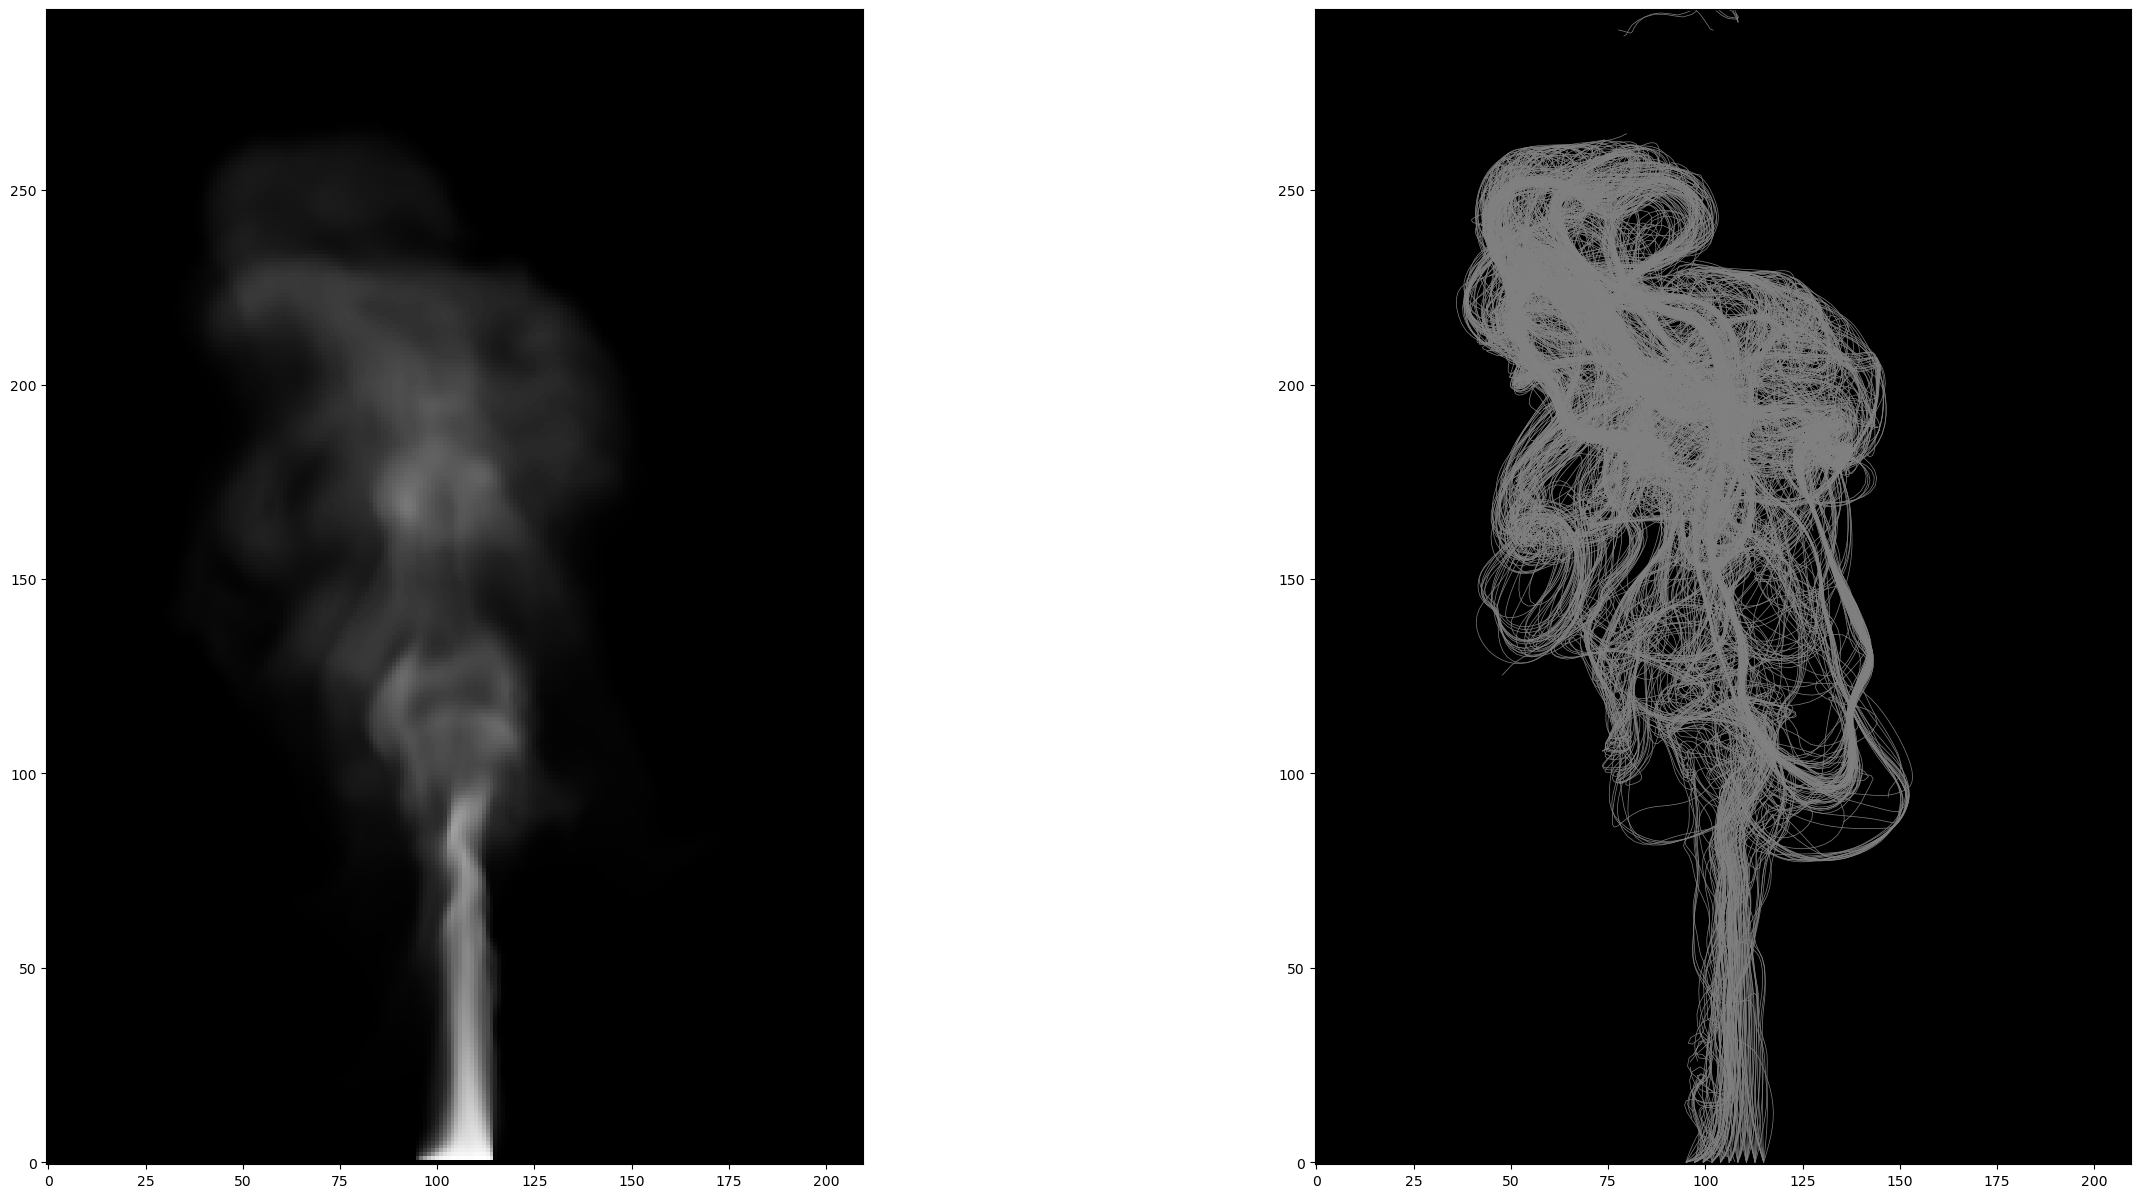

Computing 442.5's image of 450's


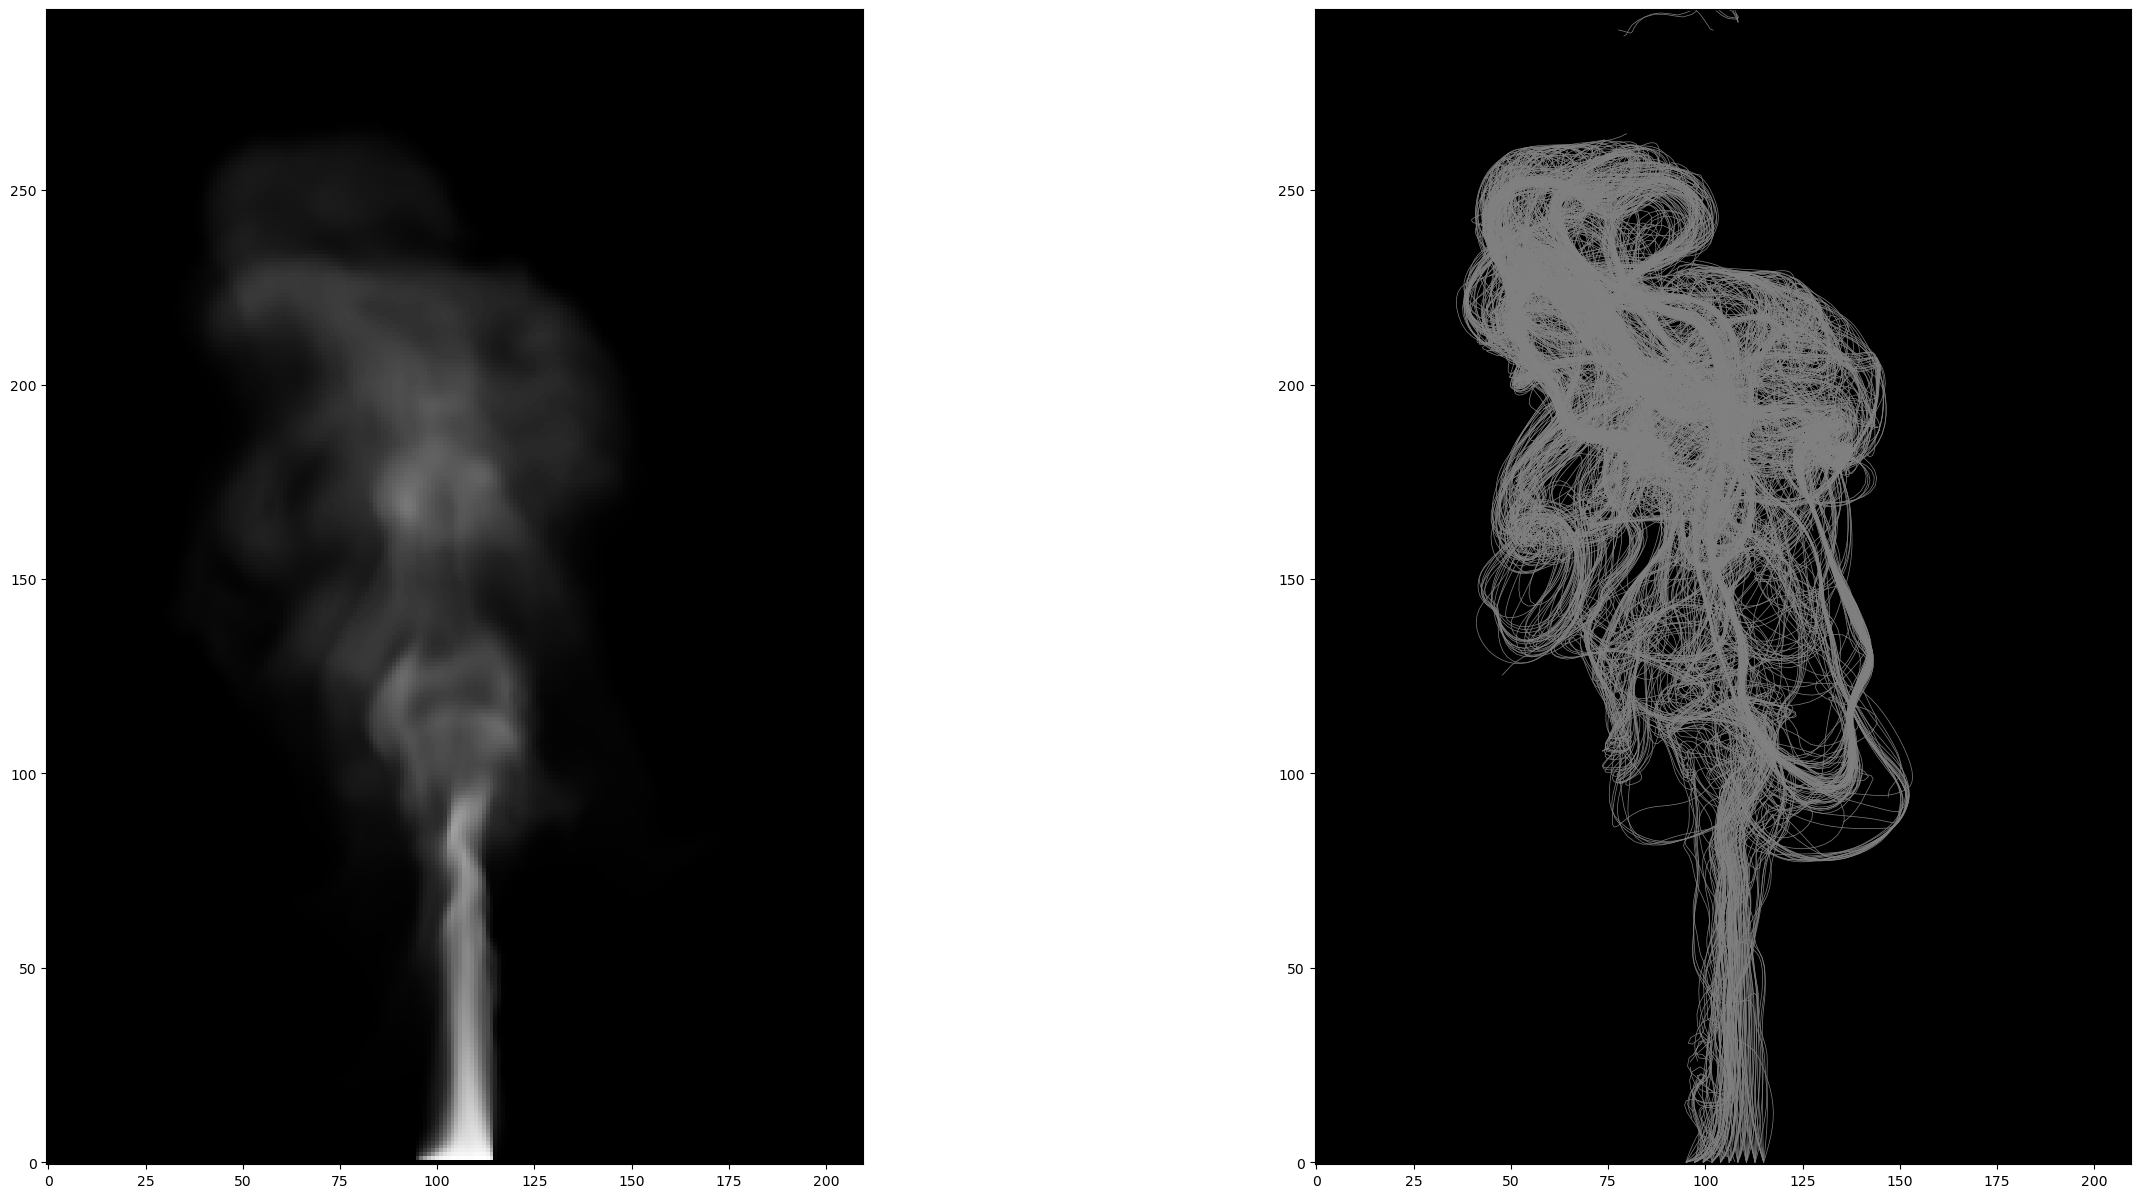

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))  # 1행 2열
im1 = axes[0].imshow(np.zeros(RESOLUTION[:2]), cmap='gray', vmin=0, vmax=1, origin="lower")
im2 = axes[1].imshow(np.zeros(RESOLUTION[:2]), cmap='gray', vmin=0, vmax=1, origin="lower")

line_segments1 = LineCollection([], colors='gray', linewidths=0.5)

axes[1].add_collection(line_segments1)

inflow_h_mask = (inflow_heat == 0)
inflow_d_mask = (inflow_dye == 0)

# x, y 범위 정의
xs = np.linspace(middle - offset, middle + offset, int(np.sqrt(num_polyline)))
ys = np.linspace(middle - offset, middle + offset, int(np.sqrt(num_polyline)))

# meshgrid로 균일 분포 생성
xx, yy = np.meshgrid(xs, ys)
zz = np.full_like(xx, z_start)  # z = 6 고정

# (num_polyline, 3) 형태로 변환
points = np.stack([xx.ravel(), yy.ravel(), zz.ravel()], axis=1)

# 원하는 polyline 형태로 복제
arr = np.tile(points[:, None, :], (1, num_points, 1))

polylines = torch.tensor(arr, dtype=torch.float32, device="cuda")

for i, t in enumerate(np.arange(0, DURATION, DT)):

    if t <= INFLOW_DURATION:
        fluid.heat = torch.where(inflow_h_mask, fluid.heat, inflow_heat)
        fluid.dye = torch.where(inflow_d_mask, fluid.dye, inflow_dye)

    fluid.heat = diffuse(fluid.heat, kappa=0.1, dt=DT, dx=1.0)
    ambient = torch.mean(fluid.heat)  # 혹은 상수 0
    dT = fluid.heat - ambient
    dv = buoyancy_a * dT * DT
    fluid.velocity[2] += dv
    
    # 열 에너지 소모 (운동에너지로 전환)
    dEk = 0.5 * dv**2   # pointwise kinetic energy 증가
    fluid.heat = torch.clamp(fluid.heat - dEk, min=0.0)
    fluid.step(dt=DT, eps_conf=0.04)

    
    polylines[:, 1:, :] = advect_polylines(fluid.velocity, polylines[:, 1:, :], DT)
    polylines = redistribute_polyline_points(polylines)
    
    
    #print(f"Computing {t}'s image of {DURATION}'s")
    if(i % 25 == 0):
        dye_cpu = fluid.dye.cpu().numpy()
        
        dye1 = dye_cpu.sum(axis=1)
        dye1 /= dye1.max()

        im1.set_data(dye1)
        projected_polylines = polylines[:, :, [0, 2]]
        drawing_polylines = get_drawing_polylines(projected_polylines)
        line_segments1.set_segments(drawing_polylines)
        
        clear_output(wait=True)
        display(fig)
        print(f"Computing {t}'s image of {DURATION}'s")


In [11]:
torch.save(polylines, '3d.pt')